In [2]:
import cobra
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sys
sys.path.append('../../code/')
import leakage
from pathlib import Path
import matplotlib
import seaborn as sns
import scipy.stats as st
from scipy.stats import mannwhitneyu

# Load model

In [3]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model.solver = 'gurobi'

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-26


In [4]:
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

# Speculations
model.reactions.PFL.knock_out()
#I'm more and more conviced that PFL is not active in aerobic conditions
# https://doi.org/10.1016/j.jbc.2021.101423

## Define environment

In [5]:
model.reactions.EX_glc__D_e.lower_bound = -10
#for r in model.exchanges:
#    r.upper_bound = 1000

In [6]:
print(model.optimize())
print(model.summary())

<Solution 0.640 at 0x7f9f99ca0c40>
Objective
1.0 BIOMASS_Ec_iJO1366_core_53p95M = 0.6398337983037605

Uptake
------
Metabolite     Reaction      Flux  C-Number  C-Flux
 prot_pool  ER_pool_TG_     0.095         0   0.00%
     ca2_e     EX_ca2_e   0.00333         0   0.00%
      cl_e      EX_cl_e   0.00333         0   0.00%
 cobalt2_e EX_cobalt2_e   1.6E-05         0   0.00%
     cu2_e     EX_cu2_e 0.0004536         0   0.00%
     fe2_e     EX_fe2_e   0.01028         0   0.00%
  glc__D_e  EX_glc__D_e        10         6 100.00%
       k_e       EX_k_e    0.1249         0   0.00%
     mg2_e     EX_mg2_e  0.005551         0   0.00%
     mn2_e     EX_mn2_e 0.0004421         0   0.00%
    mobd_e    EX_mobd_e 8.254E-05         0   0.00%
     nh4_e     EX_nh4_e     6.911         0   0.00%
     ni2_e     EX_ni2_e 0.0002067         0   0.00%
      o2_e      EX_o2_e     17.44         0   0.00%
      pi_e      EX_pi_e    0.6172         0   0.00%
     so4_e     EX_so4_e    0.1614         0   0.00%


# Get leakage


In [67]:
time = 7
exometabolites_folder = Path("../../data/e_coli/")
leakage_df = leakage.get_leakage(exometabolites_folder, "ecoli", time = time, unit = '/gDW')
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)
leakage_label = "Leakage (mM/gDW/h)"

In [68]:
leakage.get_growth_rate(exometabolites_folder,  "ecoli", time = time, method = 'spline')

0.4075277569350759

In [69]:
# Consider to use an earlier time-point
glucose_uptake_rate = leakage.get_glucose_uptake_rate(exometabolites_folder, "ecoli", time = time)

In [70]:
glucose_uptake_rate

-0.6849488660400703

In [71]:
# leakage_df['mM/gDW/h'] = leakage_df['Leakage (uM/h/OD)']*1e-3/0.32

In [72]:
leakage_df

,Leakage (mM/gDW/h)
Metabolite,
G6P,1.424501
F6P,2.818145
FBP,2.098847
DHAP,2.168361
GA3P,0.909586
23PG,0.862645
PEP,0.177739
R5P,0.256798
RU5P+X5P,0.132057


In [62]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
df2 = pd.merge(leakage_df, mapping_df, left_index=True, right_index=True)


In [63]:
df2.set_index('Ecoli metabolite', inplace = True)
df2.drop_duplicates(inplace = True)

# Plot a cumulative distribution of shadow prices


In [73]:
solution = model.optimize()

In [74]:
turnover_dict = {}
for m in model.metabolites:
    if m.compartment == 'c':
        total_flux = 0
        for r in m.reactions:
            flux_r = solution.fluxes[r.id]*r.get_coefficient(m.id)
            if flux_r > 0:
                total_flux += flux_r
        turnover_dict[m.id] = total_flux

In [ ]:
#sp = solution.shadow_prices
sp = leakage.estimate_shadow_prices(model, delta=0.01)

In [76]:
sp = pd.Series(sp)
sp.sort_values(inplace=True)

In [77]:
# List already excreted metabolites
exchanged_mets = []
for r in model.boundary:
    flux = solution.fluxes[r.id]
    if flux != 0:
        exchanged_mets.append(list(r.metabolites.keys())[0].id)
        

In [78]:
# Filter metabolites to only the organic metabolites where there is a turnover
met_ids =[]
sp_list = []
for m in model.metabolites:
    # Remove non-organic compounds
    if m.id[:-2].lower() in ['co2', 'hco3']:
        continue
    # Remove metabolites that are already leaked
    if m.id in exchanged_mets:
        continue
    if m.compartment == 'c':
        if sp[m.id] <0:
            if turnover_dict[m.id] >0:
                if 'C' in m.elements.keys():
                    met_ids.append(m.id)
                    sp_list.append(sp[m.id])

In [79]:
selected_sp = pd.Series(sp_list, index = met_ids)

In [80]:
# Remove NaN
selected_sp.dropna(inplace = True)

In [81]:
selected_sp.sort_values(inplace = True, ascending=False)

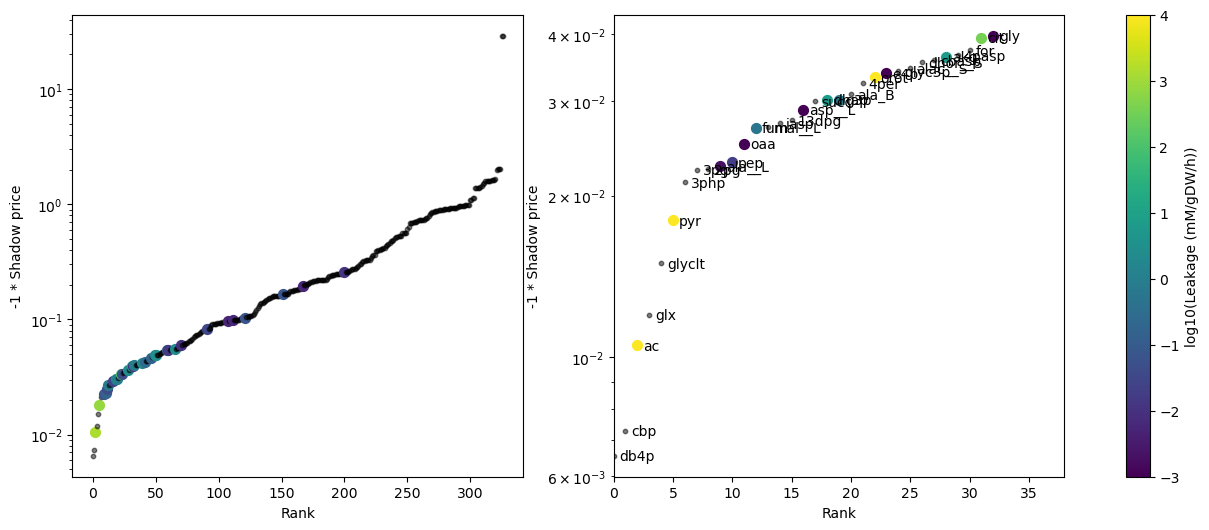

In [87]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (16,6))
smax = np.log10(df2[leakage_label].abs().max())
smin = np.log10(df2[leakage_label].abs().min())
norm = plt.Normalize(vmin=np.floor(smin), vmax=np.ceil(smax))
#norm = matplotlib.colors.BoundaryNorm([0,1,2,3], cmap.N, extend='neither')
cmap = plt.cm.viridis
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)


# Get 10% least valuable
first_x = np.ceil(0.1*len(selected_sp))

for i, (m_id, sp_i) in enumerate(selected_sp.items()):
    met_id = m_id.replace('_c', '')
    try:
        leak_i = df2.loc[met_id, leakage_label]
    except KeyError:
        leak_i = 0 
    if sp_i > 0:
        raise ValueError
    sp_abs = np.abs(sp_i)
    
    if leak_i > 0:
        ax1.scatter(i, sp_abs, s = 50, c = np.log10(leak_i), cmap = cmap, norm = norm)
    else:
        ax1.scatter(i, sp_abs,s=10, c = 'k', alpha = 0.5)
    
    # Make a seperate plot for the 10% least expensive
    if i < first_x:
        if leak_i > 0:
            ax2.scatter(i, sp_abs, s = 50, c = np.log(leak_i), cmap = cmap, norm = norm)
        else:
            ax2.scatter(i, sp_abs,s=10, c = 'k', alpha = 0.5)
        ax2.annotate(m_id[:-2], (i+0.5, sp_abs*0.98))

    
    
#ax.scatter(np.arange(len(selected_sp)), np.abs(selected_sp), s = 10)
ax1.set_yscale('log')
#ax1.set_xlim(0,400)
ax2.set_yscale('log')
ax2.set_xlim(0, first_x+5)
ax1.set_ylabel('-1 * Shadow price')
ax2.set_ylabel('-1 * Shadow price')
ax1.set_xlabel('Rank')
ax2.set_xlabel('Rank')

fig.colorbar(sm, ax = [ax1, ax2], label = "log10({0})".format(leakage_label))
plt.savefig('Rank of shadow price ecoli knock outs epsilon 001.png')

In [83]:
df2

,Leakage (mM/gDW/h),Metabolite name,Yeast metabolite
Ecoli metabolite,,,
"2pg, 3pg",0.862645,2/3-phosphoglycerate,"s_0188, s_0260"
acon_C,0.820769,Cis-aconitate,s_0516
ac,1355.552247,Acetate,s_0362
akg,2.254839,α-Ketoglutarate,s_0180
ala__L,0.067026,Alanine,s_0955
arg__L,-0.234872,Arginine,s_0965
asp__L,0.026439,Aspartate,s_0973
cit,12.796859,Citrate,s_0522
dhap,2.168361,Dihydroxyacetonephosphate,s_0629


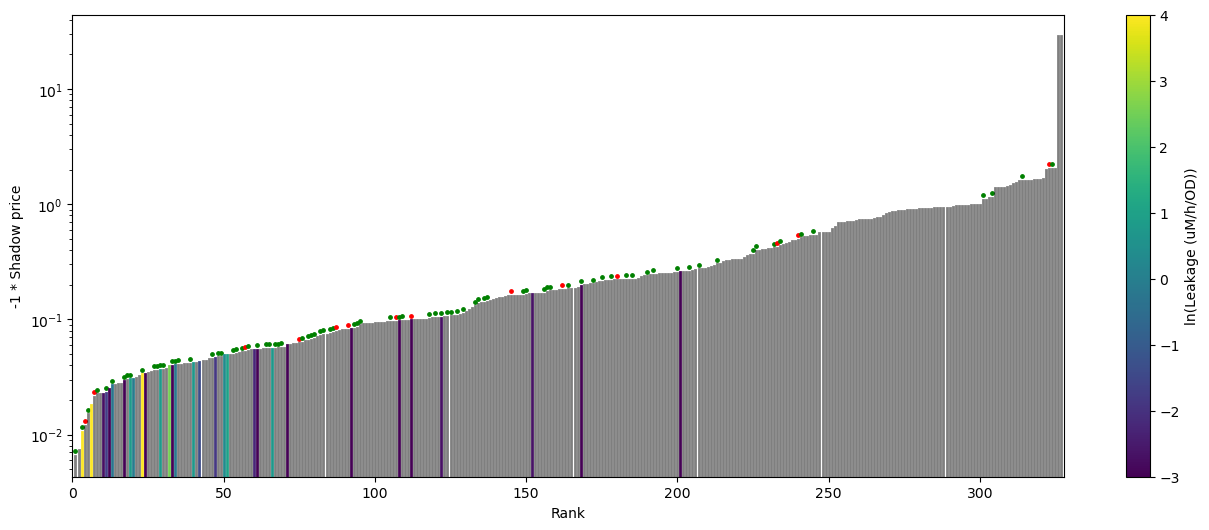

In [84]:
# fig, [ax1, ax2] = plt.subplots(1,2, figsize = (16,6))
fig, ax = plt.subplots(1, figsize = (16,6))
smax = np.log10(df2[leakage_label].abs().max())
smin = np.log10(df2[leakage_label].abs().min())
norm = plt.Normalize(vmin=np.floor(smin), vmax=np.ceil(smax))
#norm = matplotlib.colors.BoundaryNorm([0,1,2,3], cmap.N, extend='neither')
cmap = plt.cm.viridis
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i, (m_id, sp_i) in enumerate(selected_sp.items()):
    met_id = m_id.replace('_c', '')
    try:
        leak_i = df2.loc[met_id, leakage_label]
    except KeyError:
        leak_i = 0 
    if sp_i > 0:
        raise ValueError
    sp_abs = np.abs(sp_i)
    
    if leak_i > 0:
        
        ax.plot([i+1, i+1], [0, sp_abs], lw = 2, c = sm.to_rgba(np.log(leak_i)))# colouring is wrong , lw = 2)#, cmap = cmap, norm = norm)
    else:
        ax.plot([i+1,i+1], [0, sp_abs], c = 'k', alpha = 0.5, lw = 2)
    
    if met_id in consumed_mets:
        ax.scatter(i+1, sp_abs*1.1, c = 'r', s = 6)
    if met_id in produced_and_identified_mets:
        ax.scatter(i+1, sp_abs*1.1, c = 'g', s = 6)
    
    # # Make a seperate plot for the 10% least expensive
    # if i < first_x:
    #     if leak_i > 0:
    #         ax2.scatter(i, sp_abs, s = 50, c = np.log(leak_i), cmap = cmap, norm = norm)
    #     else:
    #         ax2.scatter(i, sp_abs,s=10, c = 'k', alpha = 0.5)
    #     ax2.annotate(m_id[:-2], (i+0.5, sp_abs*0.9))

    
    
#ax.scatter(np.arange(len(selected_sp)), np.abs(selected_sp), s = 10)
ax.set_yscale('log')
#ax1.set_xlim(0,400)
# ax2.set_yscale('log')
# ax2.set_xlim(0, first_x+5)
ax.set_ylabel('-1 * Shadow price')
# ax2.set_ylabel('-1 * Shadow price')
ax.set_xlabel('Rank')
# ax2.set_xlabel('Rank')
ax.set_xlim(0, i+2)
fig.colorbar(sm, ax = ax, label = "og10(Leakage (uM/h/OD))")
# plt.savefig('Rank of shadow price ecoli knock outs epsilon 001.png')

-6.8449295579910965

<AxesSubplot:ylabel='Count'>

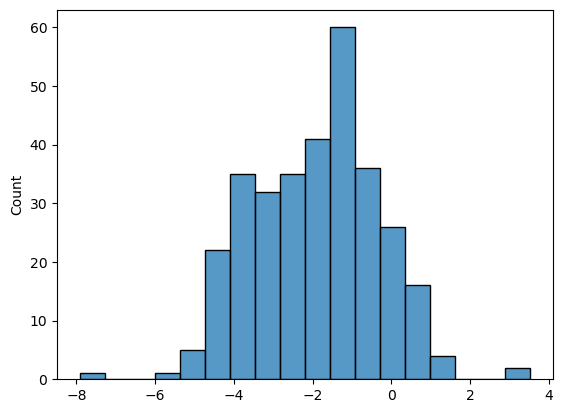

In [96]:
sns.histplot(np.log(-1*selected_sp))

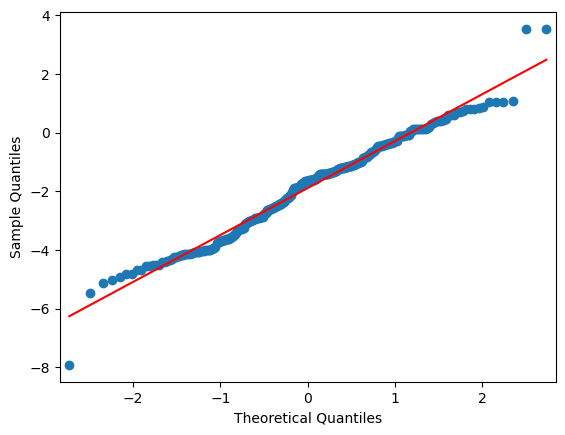

In [100]:
import statsmodels.api as sm

sm.qqplot(np.log(-1*selected_sp), line='s')
plt.show()

# Violin plot of distributions


<Axes: xlabel='Data', ylabel='ln(-Shadow price)'>

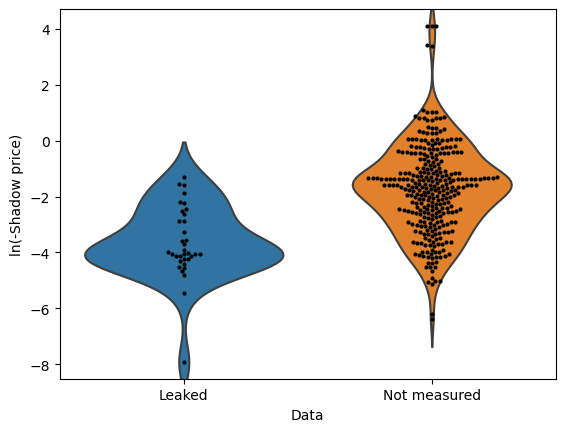

In [28]:
leaked = []
not_measured = []
df_violin = pd.DataFrame()
df_violin['ln(-Shadow price)'] = np.log(selected_sp*-1)

for i, (m_id, sp_i) in enumerate(selected_sp.items()):
    met_id = m_id.replace('_c', '')
    try:
        leak_i = leakage_df.loc[met_id, "Leakage (uM/h/OD)"]
    except KeyError:
        leaked.append("Not measured")
    else:
        leaked.append("Leaked")
df_violin["Data"] = leaked

        
# df_sp = pd.DataFrame({'Leaked':leaked, 'Not measured': not_measured})
# fig, ax = plt.subplots(1, figsize = (8,8))
g = sns.violinplot(data = df_violin, x = "Data", y = 'ln(-Shadow price)', inner = None)
sns.swarmplot(data=df_violin, x = "Data", y = 'ln(-Shadow price)', color="k", size=3, ax=g.axes)
#sns.violinplot(data=df_sp, x="age", y="class")



# Significant difference?
Now performing a mannwhitneyu, but need to chjeck whether this is appropriate

In [29]:
x = df_violin.loc[df_violin['Data']== 'Leaked', 'ln(-Shadow price)']
y = df_violin.loc[df_violin['Data']== 'Not measured', 'ln(-Shadow price)']
mannwhitneyu(x,y)

MannwhitneyuResult(statistic=1800.0, pvalue=7.875199234414919e-11)

# Check if metabolites are dispensable - Note I don't think this is useful

In [30]:
# Convert this to rel growth mu_mutant/mu_wt

In [31]:
rel_growth = []

In [32]:
wt_growth = model.slim_optimize()
for m_id, row in df_violin.iterrows():
    with model as M:
        M.metabolites.get_by_id(m_id).remove_from_model(destructive=True)
        rel_growth.append(M.slim_optimize()/wt_growth)
        

/Users/ssulheim/opt/anaconda3/envs/cobra/lib/python3.10/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [33]:
df_mdisp = df_violin.copy()
df_mdisp['Mutant relative growth'] = rel_growth

/Users/ssulheim/opt/anaconda3/envs/cobra/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Data', ylabel='Mutant relative growth'>

/Users/ssulheim/opt/anaconda3/envs/cobra/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 69.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


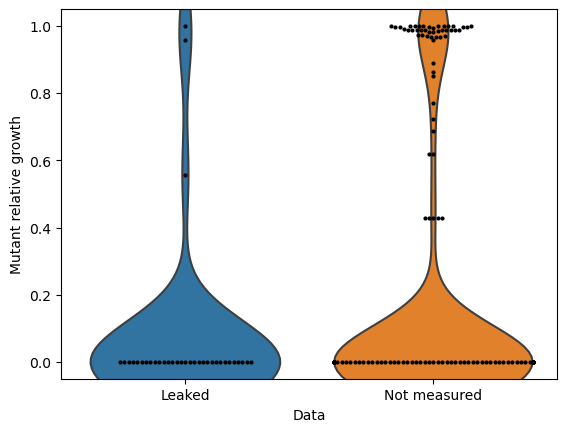

In [34]:
g = sns.violinplot(data = df_mdisp, x = 'Data', y = "Mutant relative growth", inner = None)
sns.swarmplot(data=df_mdisp, x = 'Data', y = "Mutant relative growth", color="k", size=3, ax=g.axes)

<Axes: xlabel='Mutant relative growth', ylabel='Density'>

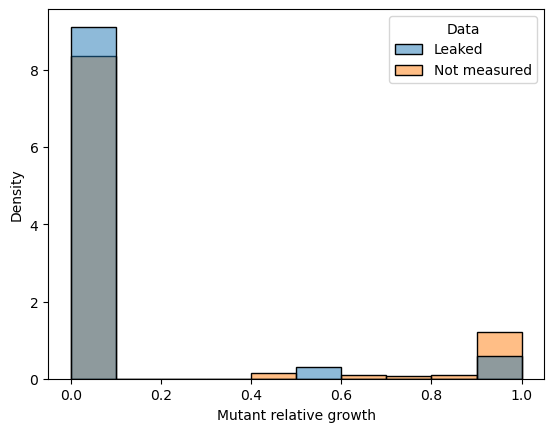

In [35]:
sns.histplot(data = df_mdisp, x = "Mutant relative growth", hue = 'Data', binwidth=0.1,  stat="density", common_norm=False)

In [36]:
df_mdisp['Rank'] = np.arange(len(df_violin))+1

(0.0, 50.0)

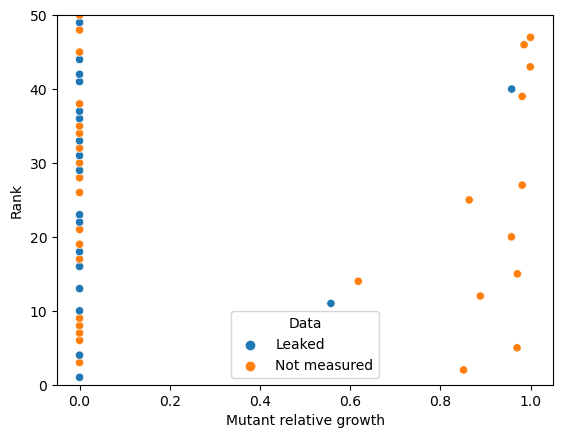

In [37]:
g = sns.scatterplot(data = df_mdisp, x = "Mutant relative growth", y = 'Rank', hue = 'Data')
g.axes.set_ylim(0,50)

In [38]:
df_mdisp.head(30)

,ln(-Shadow price),Data,Mutant relative growth,Rank
ac_c,-7.913212,Leaked,0.000000,1
q8h2_c,-6.366070,Not measured,0.851443,2
for_c,-6.193044,Not measured,0.000000,3
pyr_c,-5.455428,Leaked,0.000000,4
actp_c,-5.110344,Not measured,0.970151,5
glyclt_c,-5.072040,Not measured,0.000000,6
gcald_c,-5.026878,Not measured,0.000000,7
glx_c,-5.026691,Not measured,0.000000,8
cbp_c,-4.920288,Not measured,0.000000,9
ala__L_c,-4.808757,Leaked,0.000000,10


In [39]:
model.metabolites.btn_e.name

'Biotin'

# Plot correlation

In [ ]:
solution = model.optimize()
remove_acetate = True
shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01)

In [94]:
AA_shadow_prices = []
log_leakage = []
labels = []
for met_id, row in df2.iterrows():
    # Hack for ru5p__D
    met_id = met_id.split(',')[0]
    if row[leakage_label] > 0:
        # AA_shadow_prices.append(-1*solution.shadow_prices['{0}_c'.format(met_id)])
        AA_shadow_prices.append(-1*shadow_prices['{0}_c'.format(met_id)])
        log_leakage.append(np.log10(row[leakage_label]))
        labels.append(met_id)

if remove_acetate:
    AA_shadow_prices = AA_shadow_prices[:-1]
    log_leakage = log_leakage[:-1]
    labels = labels[:-1]

In [95]:
log10_sp = np.log10(AA_shadow_prices)

In [96]:
print(st.spearmanr(log10_sp, log_leakage))

SpearmanrResult(correlation=-0.46524064171123003, pvalue=0.006368356754720631)


In [97]:
corrp, pval = st.pearsonr(-log10_sp, log_leakage)

In [98]:
corrp, pval

(0.5984299264947694, 0.00023450511909928185)

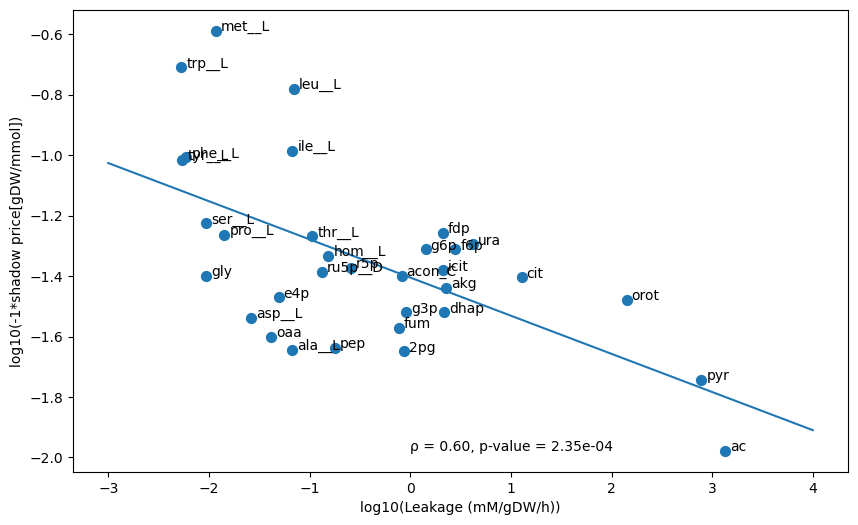

In [112]:
fig, ax = plt.subplots(1, figsize = (10, 6))
ax.scatter(log_leakage, log10_sp, s= 50)
ax.set_xlabel('log10({0})'.format(leakage_label))
ax.set_ylabel('log10(-1*shadow price[gDW/mmol])')

# Annotate each data point
for i, met_id in enumerate(labels):
    ax.annotate(met_id, (log_leakage[i]+0.05, log10_sp[i]))
# plt.title("Glucose uptake: {0}, Pearson corr: {1:.2f}, p-value: {2:.3f}".format(glucose_uptake, corrp[0], corrp[1]))

ax.annotate('ρ = {0:.2f}, p-value = {1:.2e}'.format(corrp, pval), (0, np.min(log10_sp)))#np.min(log_leakage)
# ax.annotate(r'R$_2$ = {0:.2f}'.format(res.rsquared), (10, -8.5))

trendline = np.polyfit(log_leakage, log10_sp, 1)
trendline_fun = np.poly1d(trendline)
#fun2 = lambda x: -0.7 - 0.4*x
x_arr = np.linspace(-3, 4, 100)
ax.plot(x_arr, trendline_fun(x_arr))
#ax.plot(x_arr, yfit)
plt.savefig('correlation_AA_epsilon_001.png')


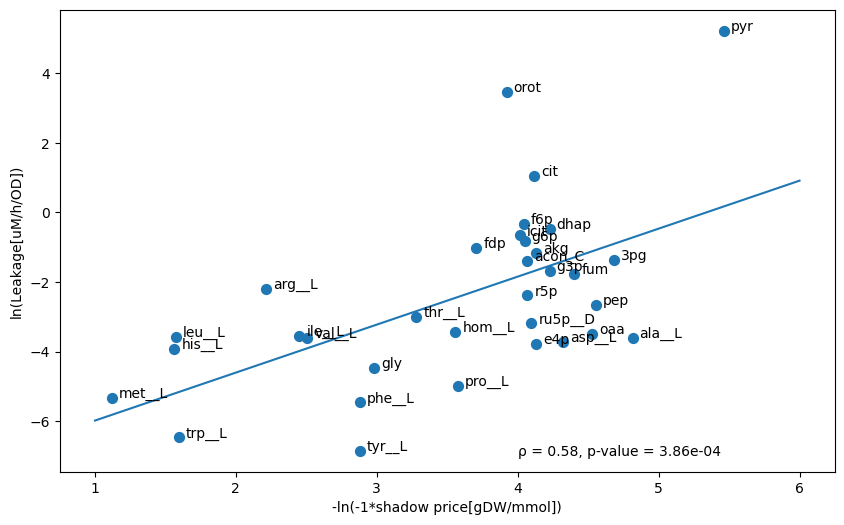

In [193]:
fig, ax = plt.subplots(1, figsize = (10, 6))
ax.scatter(-ln_sp, log_leakage, s= 50)
ax.set_ylabel('ln(Leakage[uM/h/OD])')
ax.set_xlabel('-ln(-1*shadow price[gDW/mmol])')

# Annotate each data point
for i, met_id in enumerate(labels):
    ax.annotate(met_id, (-ln_sp[i]+0.05, log_leakage[i]))
# plt.title("Glucose uptake: {0}, Pearson corr: {1:.2f}, p-value: {2:.3f}".format(glucose_uptake, corrp[0], corrp[1]))

ax.annotate('ρ = {0:.2f}, p-value = {1:.2e}'.format(corrp, pval), (4, -7))
# ax.annotate(r'R$_2$ = {0:.2f}'.format(res.rsquared), (10, -8.5))

trendline = np.polyfit(-ln_sp, log_leakage, 1)
trendline_fun = np.poly1d(trendline)
#fun2 = lambda x: -0.7 - 0.4*x
x_arr = np.linspace(1, 6, 100)
ax.plot(x_arr, trendline_fun(x_arr))
#ax.plot(x_arr, yfit)


In [185]:
pred_ln_leak = trendline[1] +(ln_sp)*trendline[0]

(-6.0, 1.0)

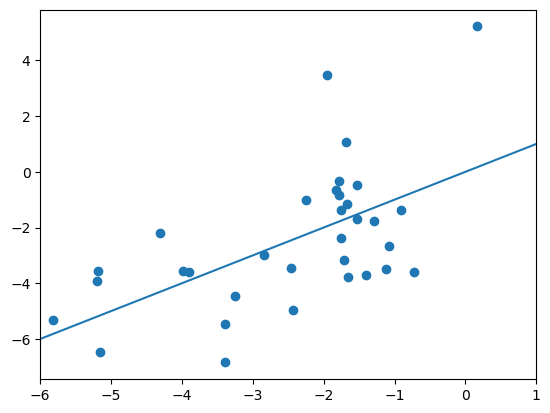

In [186]:
plt.scatter(pred_ln_leak, log_leakage)
plt.plot(np.linspace(-6, 4), np.linspace(-6, 4))
# plt.scatter(x, log_leakage)
plt.xlim(-6, 1)

In [187]:
trendline

array([-1.37814062, -7.35683574])

In [150]:
np.e**(trendline[1])

0.0006382147437780589

In [188]:
pppp = np.log(np.e**(-trendline[1])*(np.array(AA_shadow_prices))**trendline[0])

In [191]:
nnnn = np.e**(trendline[1])*(np.array(AA_shadow_prices))**trendline[0]

In [192]:
for x,y, z in zip(AA_shadow_prices, np.array(AA_shadow_prices)**trendline[0], nnnn):
    print(x, y, z)

0.017438471190411864 265.1237911779379 0.16920591245609523
0.017526436482551144 263.2916994440296 0.16803664449956102
0.024557341234054952 165.40799119885241 0.10556581872181901
0.014607249015030632 338.4408732998549 0.2159979552370894
0.014610914739388026 338.3238592155884 0.21592327512328083
0.009243286893778624 635.8830243054945 0.40582992142994834
0.010525251988824369 531.6694857769577 0.3393193046397534
0.017105896575109192 272.25351387103854 0.17375620659788107
0.01663155130577909 283.0119920336148 0.1806224259818515
0.01605640005780673 297.07707424205313 0.18959896881972732
0.01628777520864544 291.27683179143077 0.18589716857025274
0.017163663585872957 270.9915111610993 0.17295077786170998
0.018039551962611977 253.02657614846188 0.16148529146563012
0.01609320295380412 296.1412069472118 0.1890016845139399
0.012258874327253366 430.907342790197 0.27501141937092977
0.010820023008784041 511.81145141714177 0.3266456143288676
0.013306193445661307 384.8731577784853 0.24563172377864842
0

# Plot data from zampieri


In [30]:
fn_zampieri = '../../data/e_coli/zampieri_exometabolome_2019.xlsx'
df_z = pd.read_excel(fn_zampieri, sheet_name='Fitted data')

In [30]:
len (df_z)

427

## identify produced and consumed metabolites


In [31]:

min_grad = 1e-4
min_n_grad = 1
colors = []
status = []
for i, row in df_z.iterrows():
    y = row[3:]/row[3:].max()
    if sum(y.diff() > min_grad) < min_n_grad:
        # Always consumed
        status.append('Consumed')
        colors.append('r')
    elif sum(y.diff() < -min_grad) < min_n_grad:
        status.append('Produced')
        colors.append('g')
    else:
        status.append('Mixed')
        colors.append('y')


In [32]:
df_zz = pd.Series(status)

In [33]:
consumed_df = df_z[['Metabolite name', 'Metabolite id']]
consumed_df['Status'] = df_zz
consumed_df.to_csv('../../data/e_coli/zampieri_leakage_status.csv')

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_17653/3095124286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumed_df['Status'] = df_zz


In [34]:
df_zz.value_counts()

Mixed       265
Consumed     85
Produced     77
dtype: int64

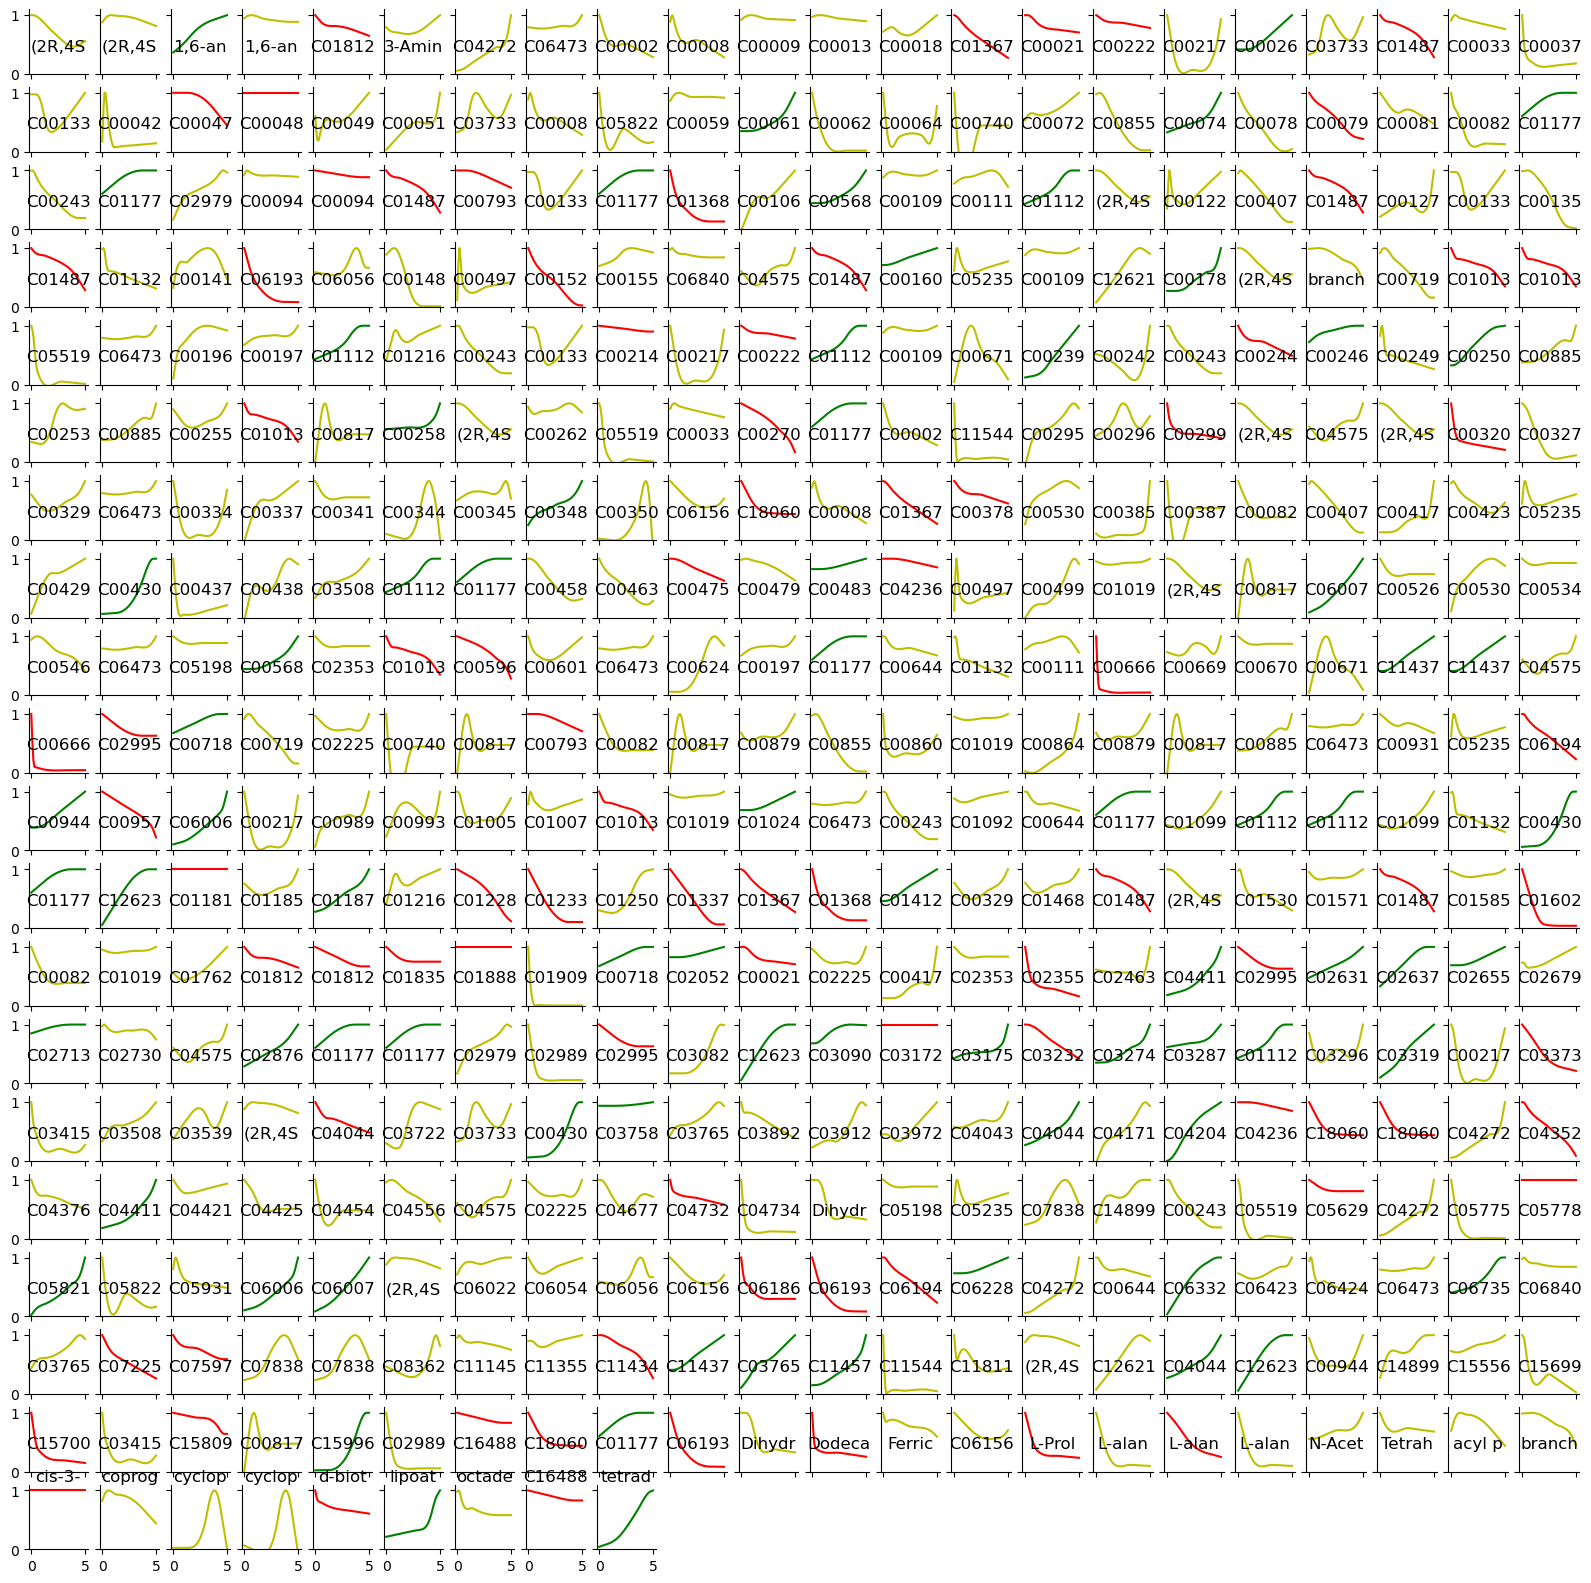

In [13]:
fig, axes = plt.subplots(20,22, figsize = (20,20), sharex = True, sharey = True)
x = df_z.columns[3::10]
n = 0

while n<len(df_z):
    i = n//22
    j = (n-22*i)%22
      
    y = df_z.iloc[n, 3::10]/df_z.iloc[n, 3::10].max()
    c = colors[n]
    y = df_z.iloc[n, 3::10]/df_z.iloc[n, 3::10].max()
    axes[i,j].plot(x, y, c = c)
    # axes[i,j].plot()
    axes[i,j].set_title(df_z.iloc[n, 1].replace("'", "")[:6], pad = -30)#, fontdict = {'fontsize': 15},)
    axes[i,j].spines[['right', 'top']].set_visible(False)
    axes[i,j].set_ylim(0,1.1)
    n += 1
while n < 20*22:
    i = n//22
    j = (n-22*i)%22
    axes[i,j].axis('off')
    n += 1
plt.savefig('Zampieri_line_plots.pdf')
plt.savefig('Zampieri_line_plots.png')

## Map metabolites to model

In [35]:
kegg_dict = {}
for m in model.metabolites:
    try:
        kegg_ids = m.annotation['kegg.compound']
    except KeyError:
        continue
    if isinstance(kegg_ids, str):
        kegg_ids = [kegg_ids]
    for k in kegg_ids:
        try:
            mets = kegg_dict[k]
        except:
            kegg_dict[k] = [m.id[:-2]]
        else:
            kegg_dict[k].append(m.id[:-2])
        

In [36]:
matched = []
matched_mets = []
for i, row in consumed_df.iterrows():
    kegg_id = row[1].strip("' ")
    try:
        mets = kegg_dict[kegg_id]
    except KeyError:
        matched.append(False)
        matched_mets.append([])
    else:
        matched.append(True)
        matched_mets.append(mets) 

In [37]:
consumed_df['Matched'] = matched
consumed_df['Matched_mets'] = matched_mets


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_17653/1273623784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumed_df['Matched'] = matched
/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_17653/1273623784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumed_df['Matched_mets'] = matched_mets


# Get list of mets that are secreted or mixed


In [39]:
mm = consumed_df.loc[consumed_df.Status!='Consumed', 'Matched_mets']
mmc = consumed_df.loc[consumed_df.Status=='Consumed', 'Matched_mets']

In [40]:
produced_and_identified_mets = [x for l in mm for x in l]
consumed_mets = [x for l in mmc for x in l]

In [41]:
consumed_df.Matched.value_counts()


True     360
False     67
Name: Matched, dtype: int64

In [40]:
consumed_df

,Metabolite name,Metabolite id,Status,Matched,Matched_mets
0,"'(2R,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahyd...","'(2R,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahyd...",Mixed,False,[]
1,"'(2R,4S)-2-methyl-2,4-dihydroxydihydrofuran-3-...","'(2R,4S)-2-methyl-2,4-dihydroxydihydrofuran-3-...",Mixed,False,[]
2,"'1,6-anhydrous-N-Acetylmuramate'","'1,6-anhydrous-N-Acetylmuramate'",Produced,False,[]
3,"'1,6-anhydrous-N-Acetylmuramyl-tripeptide'","'1,6-anhydrous-N-Acetylmuramyl-tripeptide'",Mixed,False,[]
4,'1-Acyl-sn-glycero-3-phosphoglycerol (n-C12:0)','C018126',Consumed,False,[]
...,...,...,...,...,...
422,'d-biotin d-sulfoxide','d-biotin d-sulfoxide',Consumed,False,[]
423,'lipoate (protein bound)','lipoate (protein bound)',Produced,False,[]
424,'octadecenoate (n-C18:1)','octadecenoate (n-C18:1)',Mixed,False,[]
425,'fructoselysine','C16488',Consumed,True,"[frulys_c, frulys_e, frulys_p]"


In [84]:
count_list = []
for m in model.metabolites:
    if m.compartment =='c':
        if m.id in selected_sp.index:
            pred = True
        else:
            pred = False
        if m.id[:-2] in produced_and_identified_mets:
            detected = True
        else:
            detected = False
    count_list.append([m.id, pred, detected])
        

In [85]:
count_df = pd.DataFrame(count_list, columns=['Metabolite', 'Predicted', 'Detected'])
count_df.set_index('Metabolite', inplace=True)

In [86]:
count_df.value_counts()

Predicted  Detected
False      False       1404
True       False        231
False      True          86
True       True          85
dtype: int64

In [101]:
count_df.loc[(count_df.Predicted == True) & (count_df.Detected == False),:].index

Index(['10fthf_c', '13dpg_c', '1ddecg3p_c', '1hdec9eg3p_c', '1hdecg3p_c',
       '23dhdp_c', '25aics_c', '25drapp_c', '26dap_LL_c', '26dap__M_c',
       ...
       'udcpdp_c', 'udp_c', 'ugmd_c', 'ugmda_c', 'ump_c', 'uppg3_c', 'utp_c',
       'val__L_c', 'xmp_c', 'xu5p__D_c'],
      dtype='object', name='Metabolite', length=231)